In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

In [2]:
SIZE = 15000
LOC_PRIVILEGED = 155
LOC_REGULAR = 175
PRIVILEGE_RATIO = 0.05
MIN_SCORE = 100
MAX_SCORE = 200
N_PRIV = int(SIZE * PRIVILEGE_RATIO)
N_NON_PRIV = SIZE - N_PRIV
SCALE_PRIV = 12
SCALE_REG = 15

In [3]:
np.random.seed(52)

In [4]:
# Генерація балів (нормальний розподіл, обрізаний до [100, 200])
def generate_scores(loc, scale, size, low, high):
  result = []
  while len(result) < size:
      sample = np.random.normal(loc, scale, size)
      filtered = sample[(sample >= low) & (sample <= high)]
      result.extend(filtered)
  return np.array(result[:size])

math = np.concatenate([
    generate_scores(LOC_REGULAR, SCALE_PRIV, size=N_NON_PRIV, low=MIN_SCORE, high=MAX_SCORE),
    generate_scores(LOC_PRIVILEGED, SCALE_REG, size=N_PRIV, low=MIN_SCORE, high=MAX_SCORE)
])

eng = np.concatenate([
    generate_scores(LOC_REGULAR, SCALE_PRIV, size=N_NON_PRIV, low=MIN_SCORE, high=MAX_SCORE),
    generate_scores(LOC_PRIVILEGED, SCALE_REG, size=N_PRIV, low=MIN_SCORE, high=MAX_SCORE)
])

ukr = np.concatenate([
    generate_scores(LOC_REGULAR, SCALE_PRIV, size=N_NON_PRIV, low=MIN_SCORE, high=MAX_SCORE),
    generate_scores(LOC_PRIVILEGED, SCALE_REG, size=N_PRIV, low=MIN_SCORE, high=MAX_SCORE)
])

privileges = np.array([0] * N_NON_PRIV + [1] * N_PRIV)

In [5]:
rating = 0.4 * math + 0.3 * eng + 0.3 * ukr

In [6]:
# Створення датафрейму
df = pd.DataFrame({
    'math': math,
    'eng': eng,
    'ukr': ukr,
    'privilege': privileges,
    'rating': rating,
}).sort_values(by='rating', ascending=False)

In [7]:
# Мінімальні вимоги
MIN_PASS_RATING_NON_PRIV = 160
MIN_MATH_NON_PRIV = 140
MIN_ENG_NON_PRIV = 120
MIN_UKR_NON_PRIV = 120

MIN_PASS_RATING_PRIV = 144
MIN_EACH_PRIV = 120

In [8]:
# Відбір тих, хто відповідає вимогам
eligible_non_priv = df[
    (df["privilege"] == 0) &
    (df["math"] >= MIN_MATH_NON_PRIV) &
    (df["eng"] >= MIN_ENG_NON_PRIV) &
    (df["ukr"] >= MIN_UKR_NON_PRIV) &
    (df["rating"] >= MIN_PASS_RATING_NON_PRIV)
].sort_values(by="rating", ascending=False)

eligible_priv = df[
    (df["privilege"] == 1) &
    (df[["math", "eng", "ukr"]].min(axis=1) >= MIN_EACH_PRIV) &
    (df["rating"] >= MIN_PASS_RATING_PRIV)
].sort_values(by="rating", ascending=False)

# Відбір до проходження
max_accepted = int(SIZE*350/1500)
accepted_priv = eligible_priv.head(int(max_accepted*0.1))
remaining_slots = max_accepted - len(accepted_priv)
accepted_non_priv = eligible_non_priv.head(remaining_slots)

# Об'єднання зарахованих
final_accepted = pd.concat([accepted_non_priv, accepted_priv])
final_accepted["accepted"] = 1

# Додаємо статус до всього dataframe
df["accepted"] = 0
df.loc[final_accepted.index, "accepted"] = 1

In [9]:
print(df.head())

             math         eng         ukr  privilege      rating  accepted
9455   191.404575  198.381954  196.523735          0  195.033537         1
8896   198.172197  187.471355  196.223716          0  194.377400         1
14222  195.551465  196.956691  190.208321          0  194.370090         1
2695   197.721997  192.178050  190.740618          0  193.964399         1
952    199.172148  186.357690  194.436519          0  193.907122         1


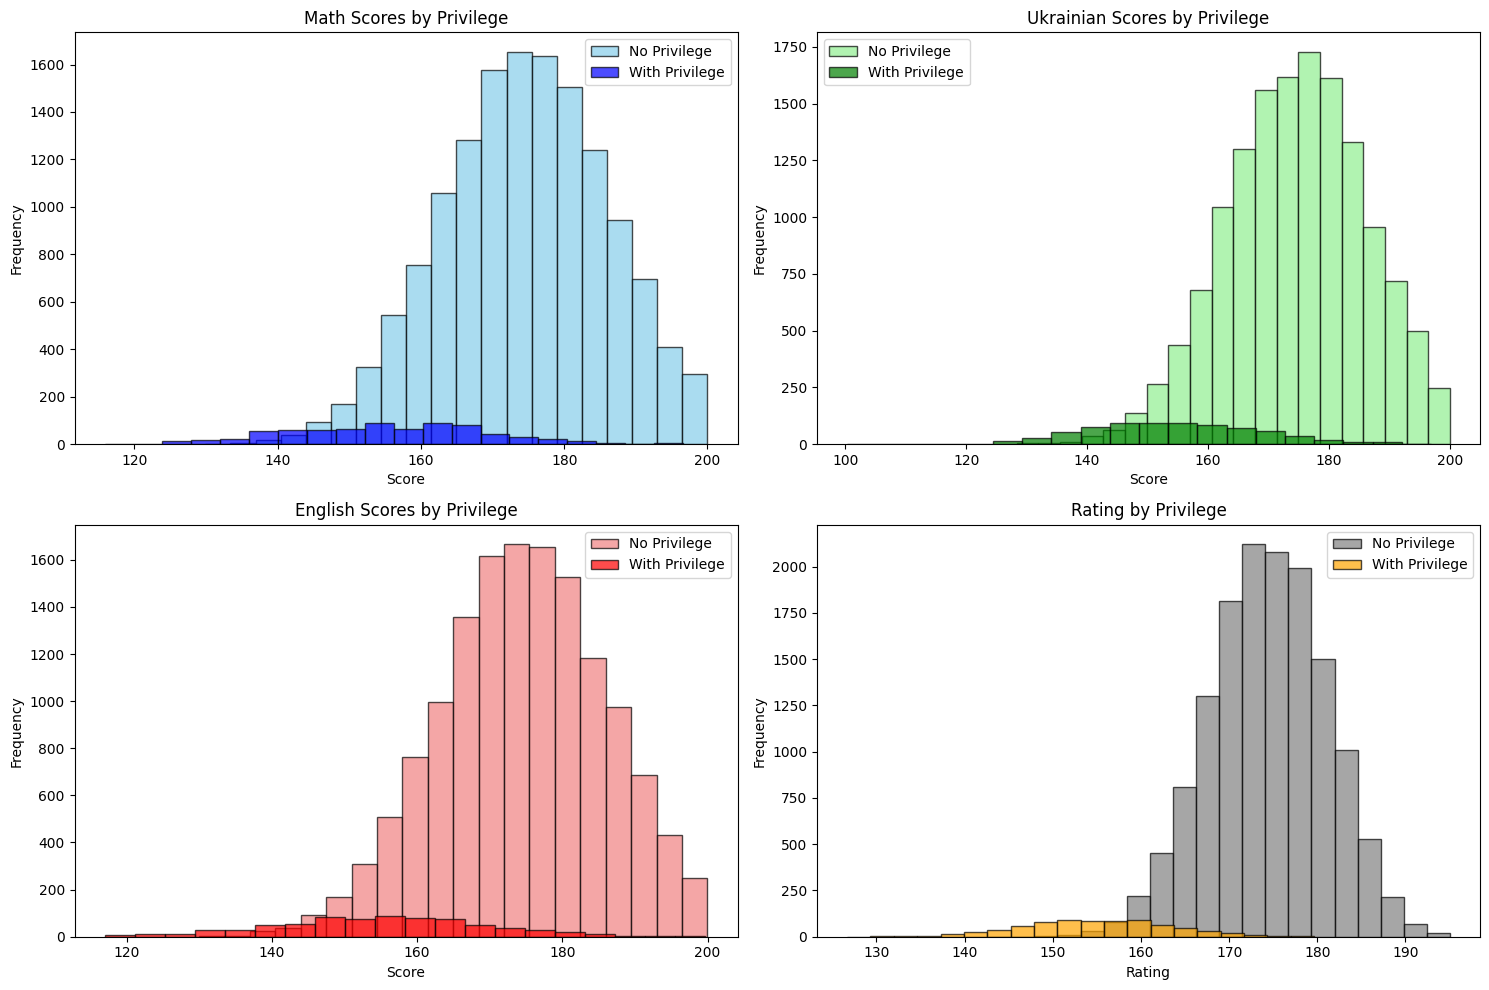

In [10]:
df_priv = df[df["privilege"] == 1]     # з пільгами
df_non_priv = df[df["privilege"] == 0] # без пільг

plt.figure(figsize=(15, 10))

# Математика
plt.subplot(2, 2, 1)
plt.hist(df_non_priv["math"], bins=20, alpha=0.7, label="No Privilege", color="skyblue", edgecolor="black")
plt.hist(df_priv["math"], bins=20, alpha=0.7, label="With Privilege", color="blue", edgecolor="black")
plt.title("Math Scores by Privilege")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()

# Українська
plt.subplot(2, 2, 2)
plt.hist(df_non_priv["ukr"], bins=20, alpha=0.7, label="No Privilege", color="lightgreen", edgecolor="black")
plt.hist(df_priv["ukr"], bins=20, alpha=0.7, label="With Privilege", color="green", edgecolor="black")
plt.title("Ukrainian Scores by Privilege")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()

# Англійська
plt.subplot(2, 2, 3)
plt.hist(df_non_priv["eng"], bins=20, alpha=0.7, label="No Privilege", color="lightcoral", edgecolor="black")
plt.hist(df_priv["eng"], bins=20, alpha=0.7, label="With Privilege", color="red", edgecolor="black")
plt.title("English Scores by Privilege")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()

# Рейтинг
plt.subplot(2, 2, 4)
plt.hist(df_non_priv["rating"], bins=20, alpha=0.7, label="No Privilege", color="gray", edgecolor="black")
plt.hist(df_priv["rating"], bins=20, alpha=0.7, label="With Privilege", color="orange", edgecolor="black")
plt.title("Rating by Privilege")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Загальні межі балів
print("Загальні результати:")
print("Максимальний рейтинг:", df["rating"].max())
print("Мінімальний рейтинг:", df["rating"].min())
print()

# Зараховані непільговики
non_priv_accepted = df[(df["accepted"] == 1) & (df["privilege"] == 0)]
print("Непільговики (зараховані):")
print("Макс. рейтинг:", non_priv_accepted["rating"].max())
print("Мін. рейтинг:", non_priv_accepted["rating"].min())
print()

# Зараховані пільговики
priv_accepted = df[(df["accepted"] == 1) & (df["privilege"] == 1)]
print("Пільговики (зараховані):")
print("Макс. рейтинг:", priv_accepted["rating"].max())
print("Мін. рейтинг:", priv_accepted["rating"].min())
print()

# Незараховані непільговики
non_priv_rejected = df[(df["accepted"] == 0) & (df["privilege"] == 0)]
print("Непільговики (НЕ зараховані):")
print("Макс. рейтинг:", non_priv_rejected["rating"].max())
print("Мін. рейтинг:", non_priv_rejected["rating"].min())
print()

# Незараховані пільговики
priv_rejected = df[(df["accepted"] == 0) & (df["privilege"] == 1)]
print("Пільговики (НЕ зараховані):")
print("Макс. рейтинг:", priv_rejected["rating"].max())
print("Мін. рейтинг:", priv_rejected["rating"].min())

Загальні результати:
Максимальний рейтинг: 195.0335366502822
Мінімальний рейтинг: 126.67365092154684

Непільговики (зараховані):
Макс. рейтинг: 195.0335366502822
Мін. рейтинг: 179.61688999484534

Пільговики (зараховані):
Макс. рейтинг: 179.64096600539796
Мін. рейтинг: 155.7995536392563

Непільговики (НЕ зараховані):
Макс. рейтинг: 179.61651954585113
Мін. рейтинг: 142.72214162843

Пільговики (НЕ зараховані):
Макс. рейтинг: 160.32002230290254
Мін. рейтинг: 126.67365092154684


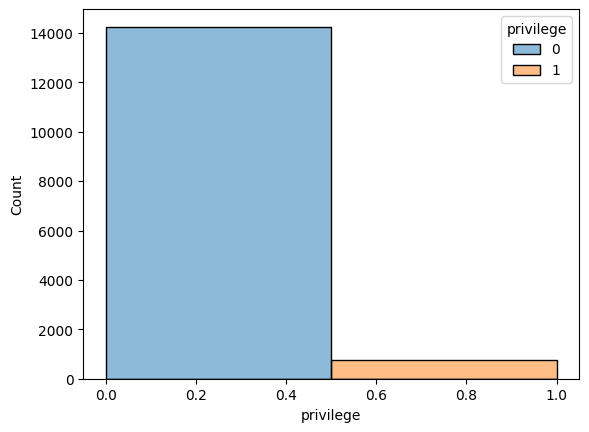

In [12]:
# Співвідношення абітурієнтів за наявністю пільги
sns.histplot(data=df, x='privilege', hue='privilege', bins=2)
plt.show()

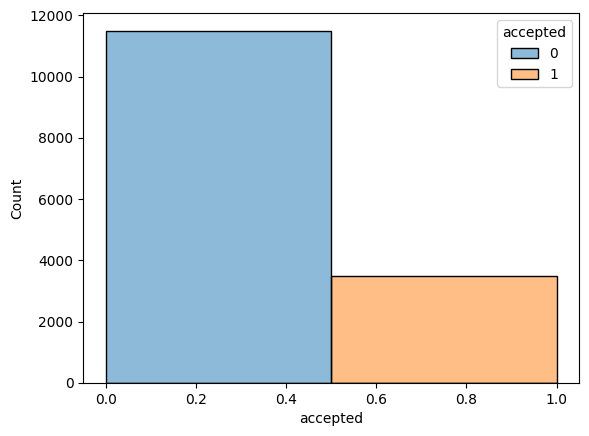

In [13]:
# Співвідношення абітурієнтів за зарахуванням
sns.histplot(data=df, x='accepted', hue='accepted', bins=2)
plt.show()

# Статистика вступників на навчальному наборі

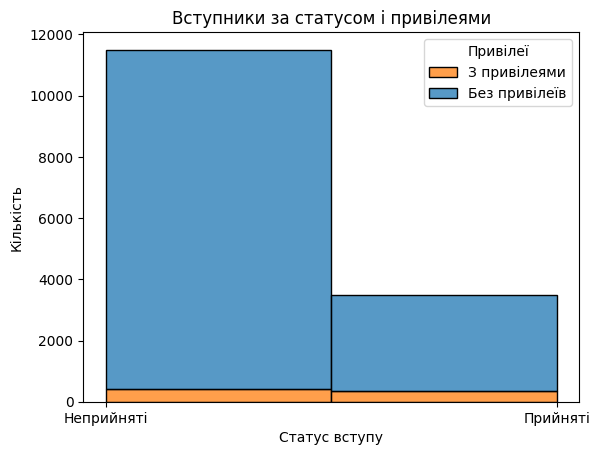

In [14]:
sns.histplot(data=df, x='accepted', hue='privilege', multiple='stack', bins=2)
plt.xticks([0, 1], ['Неприйняті', 'Прийняті'])
plt.xlabel('Статус вступу')
plt.ylabel('Кількість')
plt.title('Вступники за статусом і привілеями')
plt.legend(title='Привілеї', labels=['З привілеями', 'Без привілеїв'])
plt.show()

In [15]:
total_accepted = df['accepted'].sum()
total_rejected = len(df) - total_accepted
accepted_with_priv = df[(df['accepted'] == 1) & (df['privilege'] == 1)].shape[0]
accepted_without_priv = df[(df['accepted'] == 1) & (df['privilege'] == 0)].shape[0]

print(f"Загальна кількість заяв: {len(df)}")
print(f"Прийнято: {total_accepted}")
print(f"├── З привілеями: {accepted_with_priv}")
print(f"└── Без привілеїв: {accepted_without_priv}")
print(f"Не прийнято: {total_rejected}")

Загальна кількість заяв: 15000
Прийнято: 3500
├── З привілеями: 350
└── Без привілеїв: 3150
Не прийнято: 11500


### Формування тренувального та тестового набору, зберігаючи співвідношення вступників за пільгою

In [16]:
# Отримаємо зарахованих
accepted = df[df['accepted'] == 1]
not_accepted = df[df['accepted'] == 0]

# Стратифіковане розділення лише для зарахованих (щоб зберегти частку пільговиків)
accepted_train, accepted_test = train_test_split(
    accepted,
    test_size=0.1,
    stratify=accepted['privilege'],
    random_state=52
)

# Звичайне перемішане розділення для незарахованих
not_accepted_train, not_accepted_test = train_test_split(
    not_accepted,
    test_size=0.1,
    random_state=52
)

# Об'єднуємо назад
train = pd.concat([accepted_train, not_accepted_train])
test = pd.concat([accepted_test, not_accepted_test])

# Перемішуємо
train = train.sample(frac=1, random_state=52).reset_index(drop=True)
test = test.sample(frac=1, random_state=52).reset_index(drop=True)

X_train = train[['math', 'eng', 'ukr', 'privilege']].values
y_train = train['accepted'].values

X_test = test[['math', 'eng', 'ukr', 'privilege']].values
y_test = test['accepted'].values

In [17]:
# Масштабуємо дані
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
def build_model(arch, dropout=False, l2_reg=False, optimizer='adam'):
    model = Sequential()

    reg = l2(0.001) if l2_reg else None

    model.add(Input((4,)))
    # Перший шар (вхідний)
    model.add(Dense(arch[0], activation='relu', kernel_regularizer=reg))

    for units in arch[1:]:
        model.add(Dense(units, activation='relu', kernel_regularizer=reg))
        if dropout:
            model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))

    opt = Adam() if optimizer == 'adam' else SGD(learning_rate=0.01)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

results = []

architectures = {
    "A": ([8], False, False),
    "B": ([8, 4], False, False),
    "C": ([16, 8, 4], False, False),
    "D": ([8, 4], True, False),
    "E": ([8, 4], False, True),
    "F": ([8, 4], True, True)
}

for name, (arch, dropout, l2reg) in architectures.items():
    for opt in ['adam', 'sgd']:
        model = build_model(arch, dropout, l2reg, optimizer=opt)
        history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.2)
        y_pred = (model.predict(X_test) > 0.5).astype(int)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results.append({
            "Model": name,
            "Arch": str(arch),
            "Dropout": dropout,
            "L2": l2reg,
            "Optimizer": opt,
            "Accuracy": acc,
            "F1": f1
        })

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step


In [19]:
# Аналіз результатів
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='F1', ascending=False))

   Model        Arch  Dropout     L2 Optimizer  Accuracy        F1
8      E      [8, 4]    False   True      adam  0.994667  0.988473
10     F      [8, 4]     True   True      adam  0.994667  0.988473
0      A         [8]    False  False      adam  0.994000  0.986975
2      B      [8, 4]    False  False      adam  0.993333  0.985549
4      C  [16, 8, 4]    False  False      adam  0.992667  0.984127
5      C  [16, 8, 4]    False  False       sgd  0.986667  0.970588
6      D      [8, 4]     True  False      adam  0.982000  0.959881
1      A         [8]    False  False       sgd  0.978667  0.952941
9      E      [8, 4]    False   True       sgd  0.978667  0.952381
3      B      [8, 4]    False  False       sgd  0.978000  0.951684
7      D      [8, 4]     True  False       sgd  0.955333  0.894819
11     F      [8, 4]     True   True       sgd  0.912000  0.767606


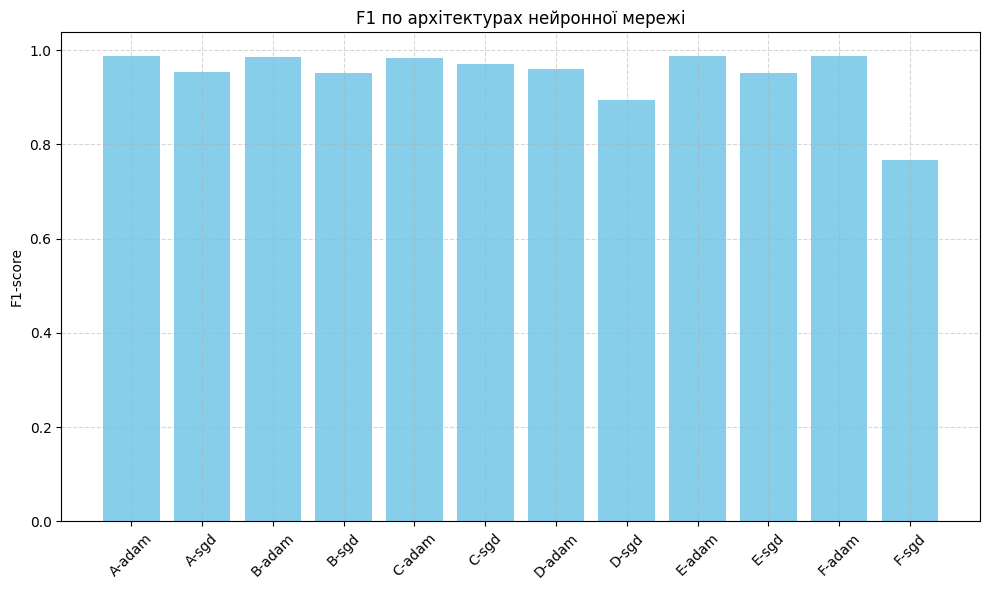

In [20]:
# Побудова діаграми F1
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'] + '-' + results_df['Optimizer'], results_df['F1'], color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("F1-score")
plt.title("F1 по архітектурах нейронної мережі")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("f1_by_model.png")
plt.show()

In [21]:
# Знайти найкращу модель за F1
best_model_info = results_df.sort_values(by='F1', ascending=False).iloc[0]
best_model_name = best_model_info['Model']
print("Найкраща модель:", best_model_info)

Найкраща модель: Model               E
Arch           [8, 4]
Dropout         False
L2               True
Optimizer        adam
Accuracy     0.994667
F1           0.988473
Name: 8, dtype: object


In [22]:
# Створити її заново
best_arch = eval(best_model_info['Arch'])
best_dropout = best_model_info['Dropout']
best_l2 = best_model_info['L2']
best_opt = best_model_info['Optimizer']

In [23]:
# Побудова та тренування найкращої моделі
best_model = build_model(best_arch, dropout=best_dropout, l2_reg=best_l2, optimizer=best_opt)
history = best_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 912us/step - accuracy: 0.7440 - loss: 0.6154 - val_accuracy: 0.7648 - val_loss: 0.3975
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.7668 - loss: 0.3635 - val_accuracy: 0.8607 - val_loss: 0.2909
Epoch 3/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.8875 - loss: 0.2651 - val_accuracy: 0.9696 - val_loss: 0.1812
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - accuracy: 0.9786 - loss: 0.1477 - val_accuracy: 0.9881 - val_loss: 0.1013
Epoch 5/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - accuracy: 0.9917 - loss: 0.0882 - val_accuracy: 0.9915 - val_loss: 0.0805
Epoch 6/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.9930 - loss: 0.0717 - val_accuracy: 0.9926 - val_loss: 0.0689
Epoch 7/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - accuracy: 0.9926 - loss: 0.0643 - val_accuracy: 0.9922 - val_loss: 0.0621
Epoch 8/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.9950 - loss: 0.0562 - 

In [24]:
# Збереження
best_model.save('best_admission_model.keras')
print("Модель збережена у файлі best_admission_model.keras")

Модель збережена у файлі best_admission_model.keras


In [25]:
# Точність
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Точність на тестовій вибірці: {accuracy:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - accuracy: 0.9964 - loss: 0.0348
Точність на тестовій вибірці: 0.9987


In [26]:
# Повний звіт
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
report = classification_report(y_test, y_pred, output_dict=True)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {report['macro avg']['precision']:.4f}")
print(f"Recall: {report['macro avg']['recall']:.4f}")
print(f"F1-score: {report['macro avg']['f1-score']:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
Accuracy: 0.9987
Precision: 0.9991
Recall: 0.9971
F1-score: 0.9981


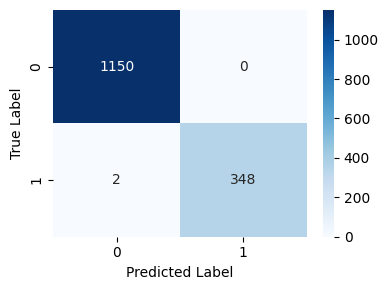

In [27]:
# Матриця помилок
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

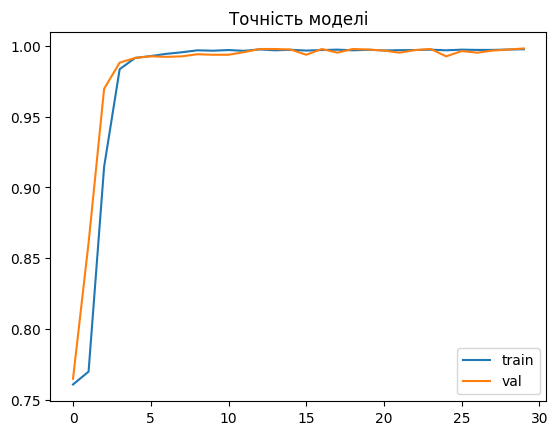

In [28]:
# Графік точності
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.title("Точність моделі")
plt.show()

In [29]:
# Приклад одного "аномального" абітурієнта
sample = np.array([[200, 200, 100, 0]])  # Без пільг
sample_scaled = scaler.transform(sample)  # масштабування, як для train-даних

prediction = best_model.predict(sample_scaled)
predicted_label = (prediction > 0.5).astype(int)

print(f"Ймовірність зарахування: {prediction[0][0]:.4f}")
print(f"Клас: {'Зараховано' if predicted_label[0][0] == 1 else 'Не зараховано'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Ймовірність зарахування: 0.0000
Клас: Не зараховано


# Статистика вступників на тренувальному наборі

In [30]:
test['prediction_prob'] = best_model.predict(X_test)
test['predicted'] = (test['prediction_prob'] > 0.5).astype(int)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step


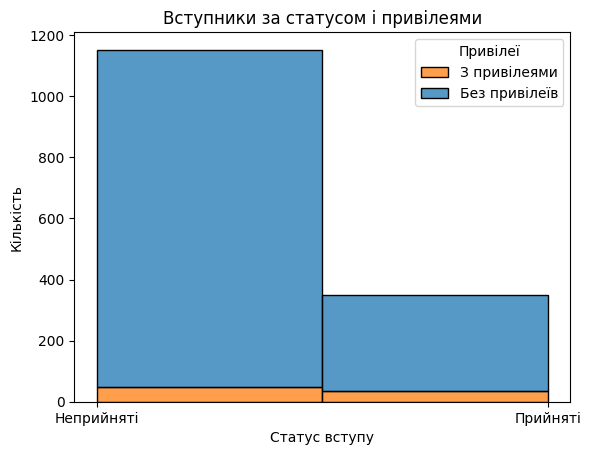

In [31]:
sns.histplot(data=test, x='predicted', hue='privilege', multiple='stack', bins=2)
plt.xticks([0, 1], ['Неприйняті', 'Прийняті'])
plt.xlabel('Статус вступу')
plt.ylabel('Кількість')
plt.title('Вступники за статусом і привілеями')
plt.legend(title='Привілеї', labels=['З привілеями', 'Без привілеїв'])
plt.show()

In [32]:
total_predicted_accepted = test['predicted'].sum()
total_predicted_rejected = len(test) - total_predicted_accepted
predicted_accepted_with_priv = test[(test['predicted'] == 1) & (test['privilege'] == 1)].shape[0]
predicted_accepted_without_priv = test[(test['predicted'] == 1) & (test['privilege'] == 0)].shape[0]

print(f"Загальна кількість заяв: {len(test)}")
print(f"Прийнято: {total_predicted_accepted}")
print(f"├── З привілеями: {predicted_accepted_with_priv}")
print(f"└── Без привілеїв: {predicted_accepted_without_priv}")
print(f"Не прийнято: {total_predicted_rejected}")

Загальна кількість заяв: 1500
Прийнято: 348
├── З привілеями: 34
└── Без привілеїв: 314
Не прийнято: 1152


In [33]:
df_final = test.sort_values(by='rating', ascending=False)

In [34]:
df_final

,math,eng,ukr,privilege,rating,accepted,prediction_prob,predicted
554,195.505462,194.432293,191.101534,0,193.862333,1,1.000000e+00,1
1347,197.156210,186.428466,194.009074,0,192.993746,1,1.000000e+00,1
5,187.005137,193.665405,199.092975,0,192.629569,1,1.000000e+00,1
859,196.920821,179.964110,196.805729,0,191.799280,1,1.000000e+00,1
422,198.957001,173.753001,195.580442,0,190.382833,1,1.000000e+00,1
...,...,...,...,...,...,...,...,...
21,138.232688,132.747726,148.432916,1,139.647268,0,2.370147e-14,0
383,141.071079,137.477822,137.770650,1,139.002973,0,7.387930e-15,0
382,139.506774,135.615607,134.330043,1,136.786404,0,1.526638e-16,0
285,128.814173,148.669390,128.021650,1,134.532981,0,1.747943e-18,0


In [ ]:
# Збереження в CSV
df_final[['math', 'eng', 'ukr', 'privilege', 'rating', 'prediction_prob']].to_csv("accepted_applicants.csv", index=False)

In [37]:
# Збереження в Excel
df_final[['math', 'eng', 'ukr', 'privilege', 'rating', 'prediction_prob']].to_excel("accepted_applicants.xlsx", index=False)